## Описание структуры базы данных

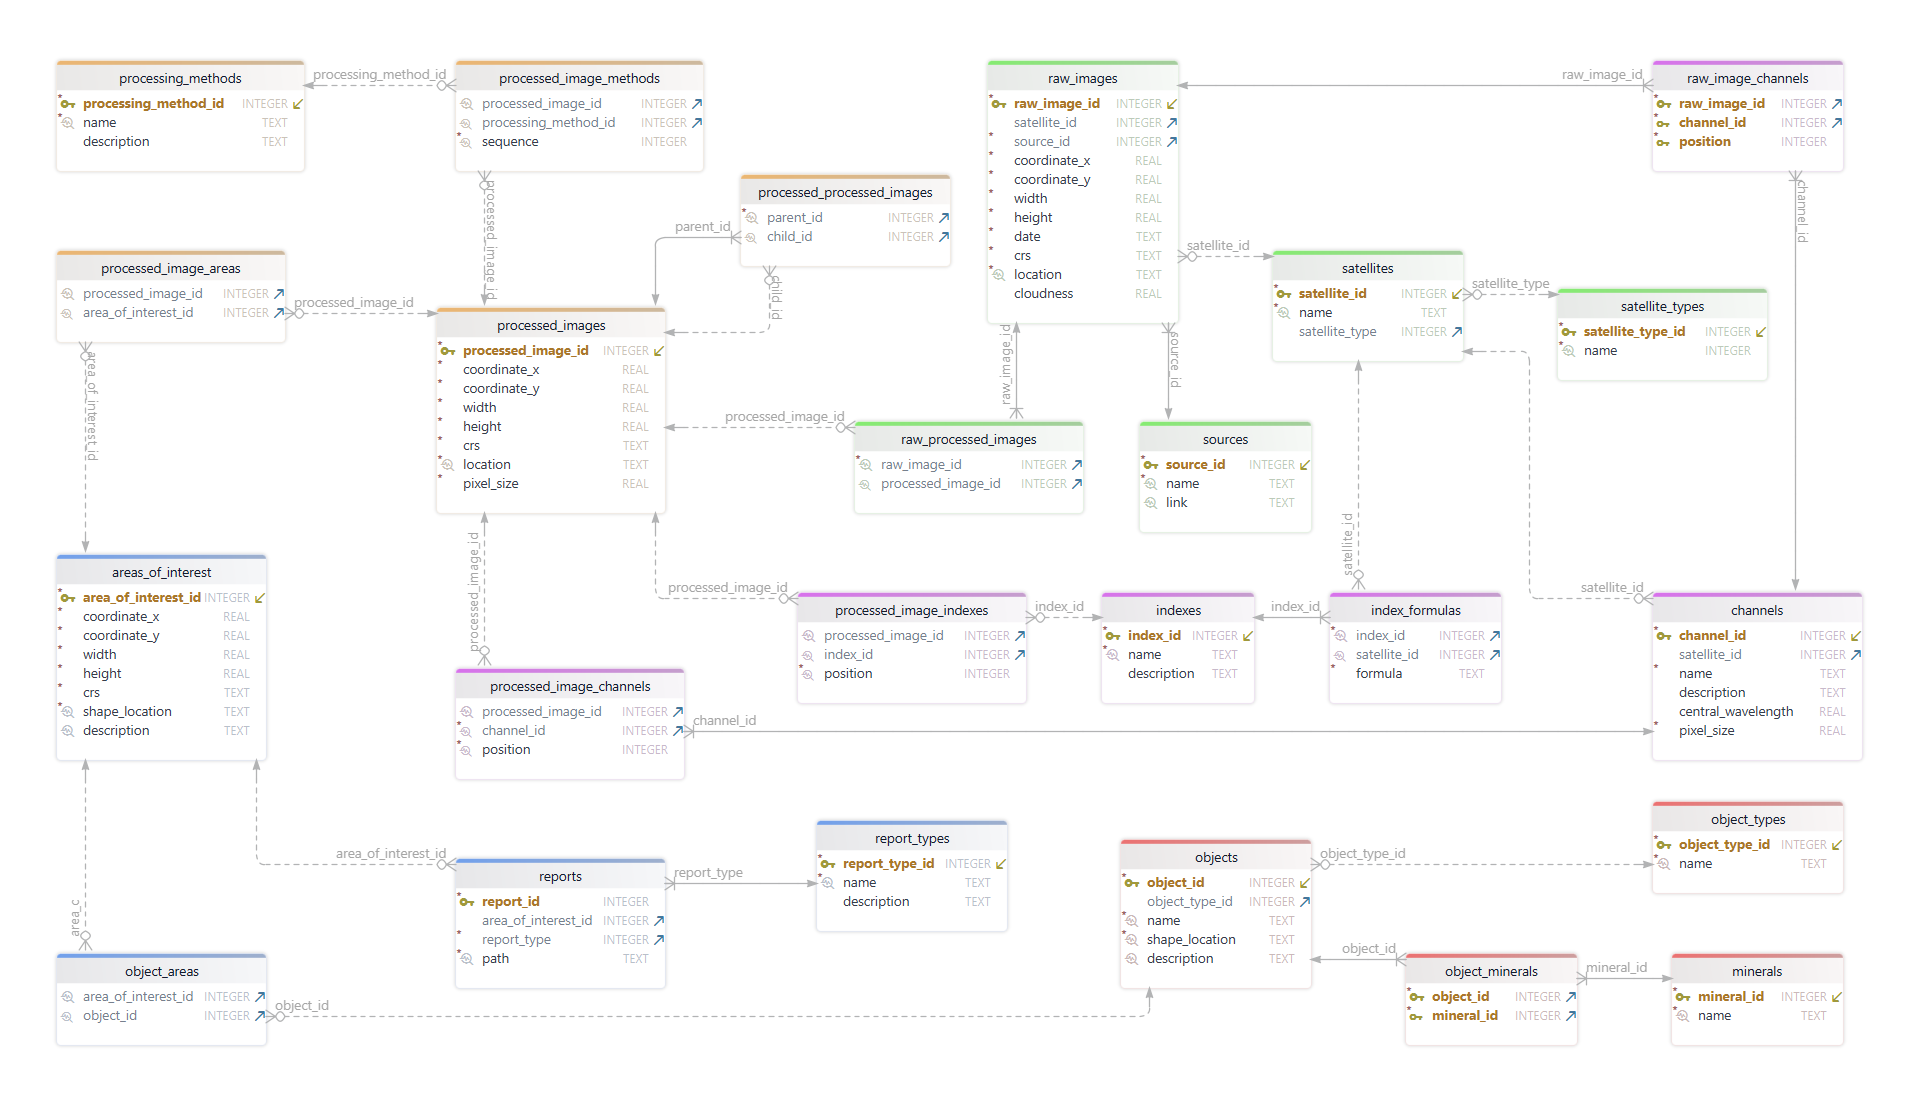

#### Основные таблицы
- **Спутники**               - устройства, передающие снимки территории земли
- **Необработанные снимки**  - первичные данные
- **Источники**              - интернет ресурсы, предоставляющие спутниковые данные
- **Обработанные снимки**    - производные от первичных или обработанных данные
- **Методы обработки**       - методы преобразования первичных или обработанных данных
- **Каналы**                 - отдельные каналы спутниковых данных
- **Индексы**                - рассчитанные каналы
- **Области интереса**       - прямоугольные области, обрамляющие анализируемую территорию с включенными в нее объектами интереса
- **Объекты**                - отдельные наземные сущности
- **Отчеты**                 - документы с результатами проведенных анализов областей интереса

## Взаимодействие с базой данных

In [2]:
import sqlite3
import pandas as pd

### Классы объектов

In [3]:
class AreaOfInterest:
    def __init__(self, id, x, y, width, height, crs, location, description):
        self.id = id
        self.x = x
        self.y = y
        self.width = width
        self.height = height
        self.crs = crs
        self.location = location
        self.description = description

    def __str__(self):
        string = ""
        string += "Area of interest\n"
        string += f"ID: {self.id}" + "\n"
        string += f"Location: {self.location}" + "\n"
        string += f"Description: {self.description}" + "\n"
        string += f"CRS: {self.crs}" + "\n"
        string += f"X: {self.x}" + "\n"
        string += f"Y: {self.y}" + "\n"
        string += f"width: {self.width}" + "\n"
        string += f"height: {self.height}"
        return string

class EarthObject:
    def __init__(self, id, type, name, location, description, minerals):
        self.id = id
        self.type = type
        self.name = name
        self.location = location
        self.description = description
        self.minerals = minerals

    def __str__(self):
        string = ""
        string += "Object\n"
        string += f"ID: {self.id}" + "\n"
        string += f"Type: {self.type}" + "\n"
        string += f"Name: {self.name}" + "\n"
        string += f"Location: {self.location}" + "\n"
        string += f"Description: {self.description}" + "\n"
        string += f"Minerals: {', '.join(map(str, self.minerals))}"
        return string

class RawImage:
    def __init__(self, id, satellite_name, satellite_type, source_name, source_url, x, y, width, height, date, crs, location, cloudness, bands):
        self.id = id
        self.satellite_name = satellite_name
        self.satellite_type = satellite_type
        self.source_name = source_name
        self.source_url = source_url
        self.x = x
        self.y = y
        self.width = width
        self.height = height
        self.crs = crs
        self.date = date
        self.location = location
        self.cloudness = cloudness
        self.bands = bands

    def __str__(self):
        string = ""
        string += "Raw image\n"
        string += f"ID: {self.id}" + "\n"
        string += f"Satellite name: {self.satellite_name}" + "\n"
        string += f"Satellite type: {self.satellite_type}" + "\n"
        string += f"Source name: {self.source_name}" + "\n"
        string += f"Source url: {self.source_url}" + "\n"
        string += f"X: {self.x}" + "\n"
        string += f"Y: {self.y}" + "\n"
        string += f"Width: {self.width}" + "\n"
        string += f"Height: {self.height}" + "\n"
        string += f"CRS: {self.crs}" + "\n"
        string += f"Date: {self.date}" + "\n"
        string += f"Location: {self.location}" + "\n"
        string += f"Cloudness: {self.cloudness}" + "\n"
        string += f"Bands: {', '.join(map(str, [b[1] for b in self.bands]))}"
        return string
    
class ProcessedImage:
    def __init__(self, id, x, y, width, height, crs, location, pixel_size, date, bands, methods, sources):
        self.id = id
        self.x = x
        self.y = y
        self.width = width
        self.height = height
        self.crs = crs
        self.date = date
        self.location = location
        self.pixel_size = pixel_size
        self.bands = bands
        self.methods = methods
        self.sources = sources

    def __str__(self):
        string = ""
        string += "Raw image\n"
        string += f"ID: {self.id}" + "\n"
        string += f"X: {self.x}" + "\n"
        string += f"Y: {self.y}" + "\n"
        string += f"Width: {self.width}" + "\n"
        string += f"Height: {self.height}" + "\n"
        string += f"CRS: {self.crs}" + "\n"
        string += f"Location: {self.location}" + "\n"
        string += f"Pixel size: {self.pixel_size}" + "\n"
        string += f"Date: {self.date}" + "\n"
        string += f"Bands and indexes: {', '.join(map(str, [b[1] for b in self.bands]))}" + "\n"
        string += f"Methods: {', '.join(map(str, [m[1] for m in self.methods]))}" + "\n"
        string += f"Sources: {', '.join(map(str, self.sources))}"
        return string

### Класс базы данных

In [11]:
class InfSysDatabase:
    def __init__(self, db_name):
        self.db_name = db_name
        self.conn = sqlite3.connect(db_name)
        self.cursor = self.conn.cursor()

    def get_raw_image_by_id(self, id):
        self.cursor.execute("SELECT * FROM raw_images WHERE raw_image_id = ?", (id,))
        raw = self.cursor.fetchone()
        self.conn.commit()
        self.cursor.execute("SELECT sources.name, sources.link FROM raw_images INNER JOIN sources ON raw_images.source_id = sources.source_id WHERE raw_images.raw_image_id = ?", (id,))
        source = self.cursor.fetchone()
        self.conn.commit()
        self.cursor.execute("SELECT satellites.name, satellite_types.name FROM raw_images INNER JOIN satellites ON raw_images.satellite_id = satellites.satellite_id INNER JOIN satellite_types ON satellites.satellite_type = satellite_types.satellite_type_id WHERE raw_images.raw_image_id = ?", (id,))
        sat = self.cursor.fetchone()
        self.conn.commit()
        self.cursor.execute("SELECT DISTINCT raw_image_channels.position, channels.name FROM raw_images INNER JOIN raw_image_channels ON raw_images.raw_image_id = raw_image_channels.raw_image_id INNER JOIN channels ON raw_image_channels.channel_id = channels.channel_id WHERE raw_images.raw_image_id = ?", (id,))
        bands = self.cursor.fetchall()
        self.conn.commit()
        bands = sorted(bands, key=lambda x: x[0])
        return RawImage(raw[0], sat[0], sat[1], source[0], source[1], *raw[3:], bands)

    def get_raw_image_by_location(self, location):
        self.cursor.execute("SELECT * FROM raw_images WHERE location = ?", (location,))
        raw = self.cursor.fetchone()
        self.conn.commit()
        self.cursor.execute("SELECT sources.name, sources.link FROM raw_images INNER JOIN sources ON raw_images.source_id = sources.source_id WHERE raw_images.location = ?", (location,))
        source = self.cursor.fetchone()
        self.conn.commit()
        self.cursor.execute("SELECT satellites.name, satellite_types.name FROM raw_images INNER JOIN satellites ON raw_images.satellite_id = satellites.satellite_id INNER JOIN satellite_types ON satellites.satellite_type = satellite_types.satellite_type_id WHERE raw_images.location = ?", (location,))
        sat = self.cursor.fetchone()
        self.conn.commit()
        self.cursor.execute("SELECT DISTINCT raw_image_channels.position, channels.name FROM raw_images INNER JOIN raw_image_channels ON raw_images.raw_image_id = raw_image_channels.raw_image_id INNER JOIN channels ON raw_image_channels.channel_id = channels.channel_id WHERE raw_images.location = ?", (location,))
        bands = self.cursor.fetchall()
        self.conn.commit()
        bands = sorted(bands, key=lambda x: x[0])
        return RawImage(raw[0], sat[0], sat[1], source[0], source[1], *raw[3:], bands)
    
    def get_processed_image_by_id(self, id):
        self.cursor.execute("SELECT * FROM processed_images WHERE processed_image_id = ?", (id,))
        img = self.cursor.fetchone()
        self.conn.commit()
        self.cursor.execute("SELECT DISTINCT raw_images.date FROM processed_images INNER JOIN raw_processed_images ON processed_images.processed_image_id = raw_processed_images.processed_image_id INNER JOIN raw_images ON raw_processed_images.raw_image_id = raw_images.raw_image_id WHERE processed_images.processed_image_id = ?", (id,))
        date = self.cursor.fetchall()[0][0]
        self.conn.commit()
        self.cursor.execute("SELECT DISTINCT processed_image_channels.position, channels.name FROM processed_images INNER JOIN processed_image_channels ON processed_images.processed_image_id = processed_image_channels.processed_image_id INNER JOIN channels ON processed_image_channels.channel_id = channels.channel_id WHERE processed_images.processed_image_id = ?", (id,))
        channels = self.cursor.fetchall()
        self.conn.commit()
        self.cursor.execute("SELECT DISTINCT processed_image_indexes.position, indexes.name FROM processed_images INNER JOIN processed_image_indexes ON processed_images.processed_image_id = processed_image_indexes.processed_image_id INNER JOIN indexes ON processed_image_indexes.index_id = indexes.index_id WHERE processed_images.processed_image_id = ?", (id,))
        indexes = self.cursor.fetchall()
        self.conn.commit()
        bands = sorted(channels + indexes, key=lambda x: x[0])
        self.cursor.execute("SELECT DISTINCT processed_image_methods.sequence, processing_methods.name FROM processed_images INNER JOIN processed_image_methods ON processed_images.processed_image_id = processed_image_methods.processed_image_id INNER JOIN processing_methods ON processed_image_methods.processing_method_id = processing_methods.processing_method_id WHERE processed_images.processed_image_id = ?", (id,))
        methods = self.cursor.fetchall()
        self.conn.commit()
        methods = sorted(methods, key=lambda x: x[0])
        self.cursor.execute("SELECT DISTINCT raw_images.location FROM processed_images INNER JOIN raw_processed_images ON processed_images.processed_image_id = raw_processed_images.processed_image_id INNER JOIN raw_images ON raw_processed_images.raw_image_id = raw_images.raw_image_id WHERE processed_images.processed_image_id = ?", (id,))
        sources = self.cursor.fetchall()
        self.conn.commit()
        sources = [s[0] for s in sources]
        return ProcessedImage(*img, date, bands, methods, sources)

    def get_processed_image_by_location(self, location):
        self.cursor.execute("SELECT * FROM processed_images WHERE location = ?", (location,))
        img = self.cursor.fetchone()
        self.conn.commit()
        self.cursor.execute("SELECT DISTINCT raw_images.date FROM processed_images INNER JOIN raw_processed_images ON processed_images.processed_image_id = raw_processed_images.processed_image_id INNER JOIN raw_images ON raw_processed_images.raw_image_id = raw_images.raw_image_id WHERE processed_images.location = ?", (location,))
        date = self.cursor.fetchall()[0][0]
        self.conn.commit()
        self.cursor.execute("SELECT DISTINCT processed_image_channels.position, channels.name FROM processed_images INNER JOIN processed_image_channels ON processed_images.processed_image_id = processed_image_channels.processed_image_id INNER JOIN channels ON processed_image_channels.channel_id = channels.channel_id WHERE processed_images.location = ?", (location,))
        channels = self.cursor.fetchall()
        self.conn.commit()
        self.cursor.execute("SELECT DISTINCT processed_image_indexes.position, indexes.name FROM processed_images INNER JOIN processed_image_indexes ON processed_images.processed_image_id = processed_image_indexes.processed_image_id INNER JOIN indexes ON processed_image_indexes.index_id = indexes.index_id WHERE processed_images.location = ?", (location,))
        indexes = self.cursor.fetchall()
        self.conn.commit()
        bands = sorted(channels + indexes, key=lambda x: x[0])
        self.cursor.execute("SELECT DISTINCT processed_image_methods.sequence, processing_methods.name FROM processed_images INNER JOIN processed_image_methods ON processed_images.processed_image_id = processed_image_methods.processed_image_id INNER JOIN processing_methods ON processed_image_methods.processing_method_id = processing_methods.processing_method_id WHERE processed_images.location = ?", (location,))
        methods = self.cursor.fetchall()
        self.conn.commit()
        methods = sorted(methods, key=lambda x: x[0])
        self.cursor.execute("SELECT DISTINCT raw_images.location FROM processed_images INNER JOIN raw_processed_images ON processed_images.processed_image_id = raw_processed_images.processed_image_id INNER JOIN raw_images ON raw_processed_images.raw_image_id = raw_images.raw_image_id WHERE processed_images.location = ?", (location,))
        sources = self.cursor.fetchall()
        self.conn.commit()
        sources = [s[0] for s in sources]
        return ProcessedImage(*img, date, bands, methods, sources)

    def get_area_of_interest_by_id(self, id):
        self.cursor.execute("SELECT * FROM areas_of_interest WHERE area_of_interest_id = ?", (id,))
        result = self.cursor.fetchone()
        self.conn.commit()
        return AreaOfInterest(*result)

    def get_area_of_interest_by_location(self, location):
        self.cursor.execute("SELECT * FROM areas_of_interest WHERE location = ?", (location,))
        result = self.cursor.fetchone()
        self.conn.commit()
        return AreaOfInterest(*result)
    
    def get_object_by_id(self, id):
        self.cursor.execute("SELECT * FROM objects WHERE object_id = ?", (id,))
        object = self.cursor.fetchone()
        self.conn.commit()
        self.cursor.execute("SELECT DISTINCT minerals.name FROM object_minerals INNER JOIN minerals ON object_minerals.mineral_id = minerals.mineral_id WHERE object_id = ?", (id,))
        minerals = [m[0] for m in self.cursor.fetchall()]
        self.conn.commit()
        self.cursor.execute("SELECT DISTINCT object_types.name FROM objects INNER JOIN object_types ON objects.object_type_id = object_types.object_type_id WHERE object_id = ?", (id,))
        type = self.cursor.fetchone()[0]
        self.conn.commit()
        return EarthObject(object[0], type, object[2], object[3], object[4], minerals)
    
    def get_object_by_name(self, name):
        self.cursor.execute("SELECT * FROM objects WHERE name = ?", (name,))
        object = self.cursor.fetchone()
        self.conn.commit()
        self.cursor.execute("SELECT DISTINCT minerals.name FROM objects INNER JOIN object_minerals ON objects.object_id = object_minerals.object_id INNER JOIN minerals ON object_minerals.mineral_id = minerals.mineral_id WHERE objects.name = ?", (name,))
        minerals = [m[0] for m in self.cursor.fetchall()]
        self.conn.commit()
        self.cursor.execute("SELECT DISTINCT object_types.name FROM objects INNER JOIN object_types ON objects.object_type_id = object_types.object_type_id WHERE objects.name = ?", (name,))
        type = self.cursor.fetchone()[0]
        self.conn.commit()
        return EarthObject(object[0], type, object[2], object[3], object[4], minerals)

    def get_report_by_id(self, id):
        self.cursor.execute("SELECT path FROM reports WHERE report_id = ?", (id,))
        report = self.cursor.fetchone()
        self.conn.commit()
        report = pd.read_csv(report[0])
        return report

    def close(self): 
        self.conn.close()
        print("Database connection closed.")
    
    def __del__(self):
        if self.conn:
            self.conn.close()
            print(f"Database connection closed.")

### Подключение к базе данных

In [12]:
db = InfSysDatabase("db.sqlite")

### Получение информации об объекте

In [6]:
print(db.get_object_by_id(0))

Object
ID: 0
Type: quarry
Name: korfovskiy
Location: example\shapes\korfovskiy_quarry_20240717.shp
Description: 
Minerals: granodiorite


### Получение информации об области интереса

In [7]:
print(db.get_area_of_interest_by_id(0))

Area of interest
ID: 0
Location: example\shapes\korfovskiy_aoi_epsg32653.shp
Description: 
CRS: EPSG:32653
X: 503112.62847842294
Y: 504606.555508172
width: 1493.927029749029
height: 1142.4147874573246


### Получение информации о необработанном спутниковом снимке

In [8]:
print(db.get_raw_image_by_id(0))

Raw image
ID: 0
Satellite name: Sentinel 2
Satellite type: passive
Source name: Google Earth Engine
Source url: https://earthengine.google.com/
X: 135.01732619233454
Y: 48.23584766455341
Width: 811.0
Height: 540.0
CRS: EPSG:4326
Date: 20240717
Location: example\raw\S2H_korfovskiy_20240717.tif
Cloudness: None
Bands: Band 1, Band 2, Band 3, Band 4, Band 5, Band 6, Band 7, Band 8, Band 8A, Band 9, Band 10, Band 11, Band 12


### Получение информации оо обработанном спутниковом снимке

In [9]:
print(db.get_processed_image_by_id(0))

Raw image
ID: 0
X: 501286.55415444874
Y: 5342518.18406584
Width: 541.0
Height: 539.0
CRS: EPSG:32653
Location: example\processed\sentinel2_korfovskiy_20240717.tif
Pixel size: 9.999999999999998
Date: 20240717
Bands and indexes: Band 2, Band 3, Band 4, Band 5, Band 6, Band 7, Band 8, Band 11, Band 12
Methods: noise cancelling, normalization, reprojection, scaling
Sources: example\raw\S2H_korfovskiy_20240717.tif


### Получение отчета

In [13]:
print(db.get_report_by_id(0))

    Год     Спутник  Площадь с растительностью, кв. м  \
0  2004   Landsat 5                            757324   
1  2008   Landsat 5                            698268   
2  2013   Landsat 5                            662290   
3  2018   Landsat 8                            482444   
4  2023  Sentinel-2                            371996   

   Площадь без растительности, кв. м            %A        1 - %A  \
0                             534514  0,5810932747  0,4189067253   
1                             593571  0,6452966923  0,3547033077   
2                             629548  0,6844088441  0,3155911559   
3                             809394  0,8799272049  0,1200727951   
4                             919842             1             0   

             %B        1 - %B  
0  0,4137624067  0,5862375933  
1  0,4594778912  0,5405221088  
2  0,4873273584  0,5126726416  
3  0,6265445048  0,3734554952  
4  0,7120412931  0,2879587069  
